In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'

# SED folder path
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Load the datasets
dataset_gt_train = np.load(data_dir + 'train_10000_stars_id_001_8bins.npy', allow_pickle=True)[()]
print(dataset_gt_train.keys())
dataset_gt_test = np.load(data_dir + 'test_1000_stars_id_001_8bins.npy', allow_pickle=True)[()]

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR'])


In [3]:
noisy = False
if noisy == True:
    obs_type = 'noisy_stars'
else:
    obs_type = 'stars'

# Compute the star spectral energy distribution estimation
diff_train = []
for i in range(dataset_gt_train['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_gt_train['mono_psfs'][i]]))
    diff_train.append((1-diff)/np.max(1-diff))
diff_train = np.array(diff_train)
print(diff_train.shape)

diff_test = []
for i in range(dataset_gt_test['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_gt_test[obs_type][i])**2) for mono_psf in dataset_gt_test['mono_psfs'][i]]))
    diff_test.append((1-diff)/np.max(1-diff))
diff_test = np.array(diff_test)
print(diff_test.shape)

(10000, 8)
(1000, 8)


In [4]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(diff_train, dataset_gt_train['SED_ids'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [5]:
predictions = clf.predict(diff_test)

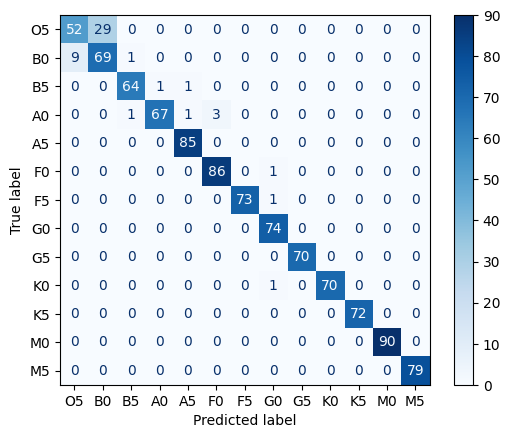

Accuracy:  0.951
Relaxed accuracy:  0.994


In [6]:
star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']
cm = confusion_matrix(dataset_gt_test['SED_ids'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = np.trace(cm)/np.sum(cm)
relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)

print('Accuracy: ', accuracy)
print('Relaxed accuracy: ', relaxed_accuracy)

# Train with the approximated dataset

In [36]:
n_zks_list = [66, 45, 25, 15]
# Load the datasets
datasets_train = [np.load(data_dir + 'train_10000_stars_id_001_8bins_{}zks_rms_1e-02.npy'.format(n_zks), allow_pickle=True)[()] for n_zks in n_zks_list]
datasets_test = [np.load(data_dir + 'test_1000_stars_id_001_8bins_{}zks_rms_1e-02.npy'.format(n_zks), allow_pickle=True)[()] for n_zks in n_zks_list]


In [37]:
diff_train_list = []
diff_test_list = []
# Compute the star spectral energy distribution estimation for each dataset
for dataset_train, dataset_test in zip(datasets_train, datasets_test):
    diff_train = []
    for i in range(dataset_train['parameters']['n_stars']):
        diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_train['mono_psfs'][i]]))
        diff_train.append((1-diff)/np.max(1-diff))
    diff_train_list.append( np.array(diff_train) )

    diff_test = []
    for i in range(dataset_test['parameters']['n_stars']):
        diff = (np.array([np.sum((mono_psf-dataset_gt_test[obs_type][i])**2) for mono_psf in dataset_test['mono_psfs'][i]]))
        diff_test.append((1-diff)/np.max(1-diff))
    diff_test_list.append( np.array(diff_test) )


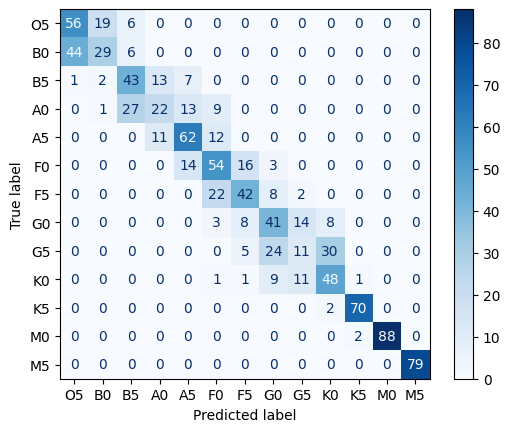

n_zks:  66
Accuracy:  0.645
Relaxed accuracy:  0.944
---------------------------------


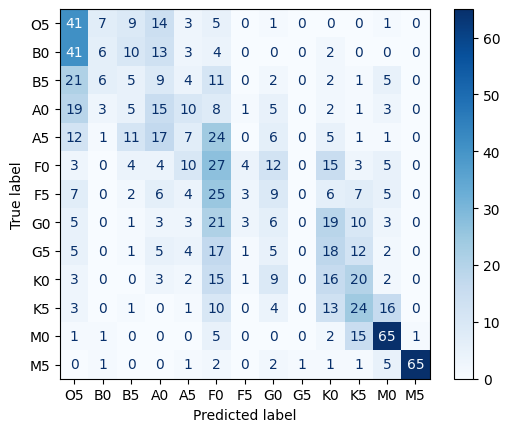

n_zks:  45
Accuracy:  0.28
Relaxed accuracy:  0.553
---------------------------------


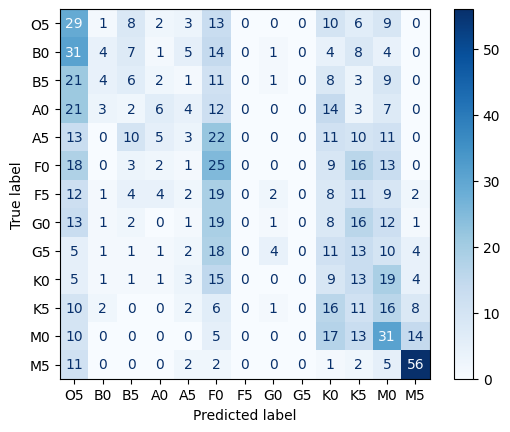

n_zks:  25
Accuracy:  0.181
Relaxed accuracy:  0.373
---------------------------------


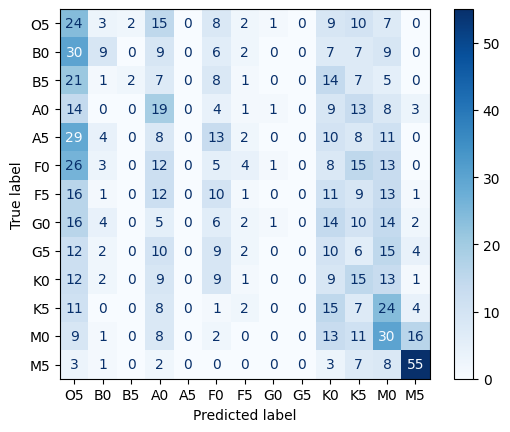

n_zks:  15
Accuracy:  0.162
Relaxed accuracy:  0.339
---------------------------------


In [38]:
cm_list = []
for diff_train, diff_test, n_zks in zip(diff_train_list, diff_test_list, n_zks_list):
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(diff_train, dataset_train['SED_ids'])
    predictions = clf.predict(diff_test)

    cm = confusion_matrix(dataset_test['SED_ids'], predictions)
    cm_list.append(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    accuracy = np.trace(cm)/np.sum(cm)
    relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)

    print('n_zks: ', n_zks)
    print('Accuracy: ', accuracy)
    print('Relaxed accuracy: ', relaxed_accuracy)
    print('---------------------------------')


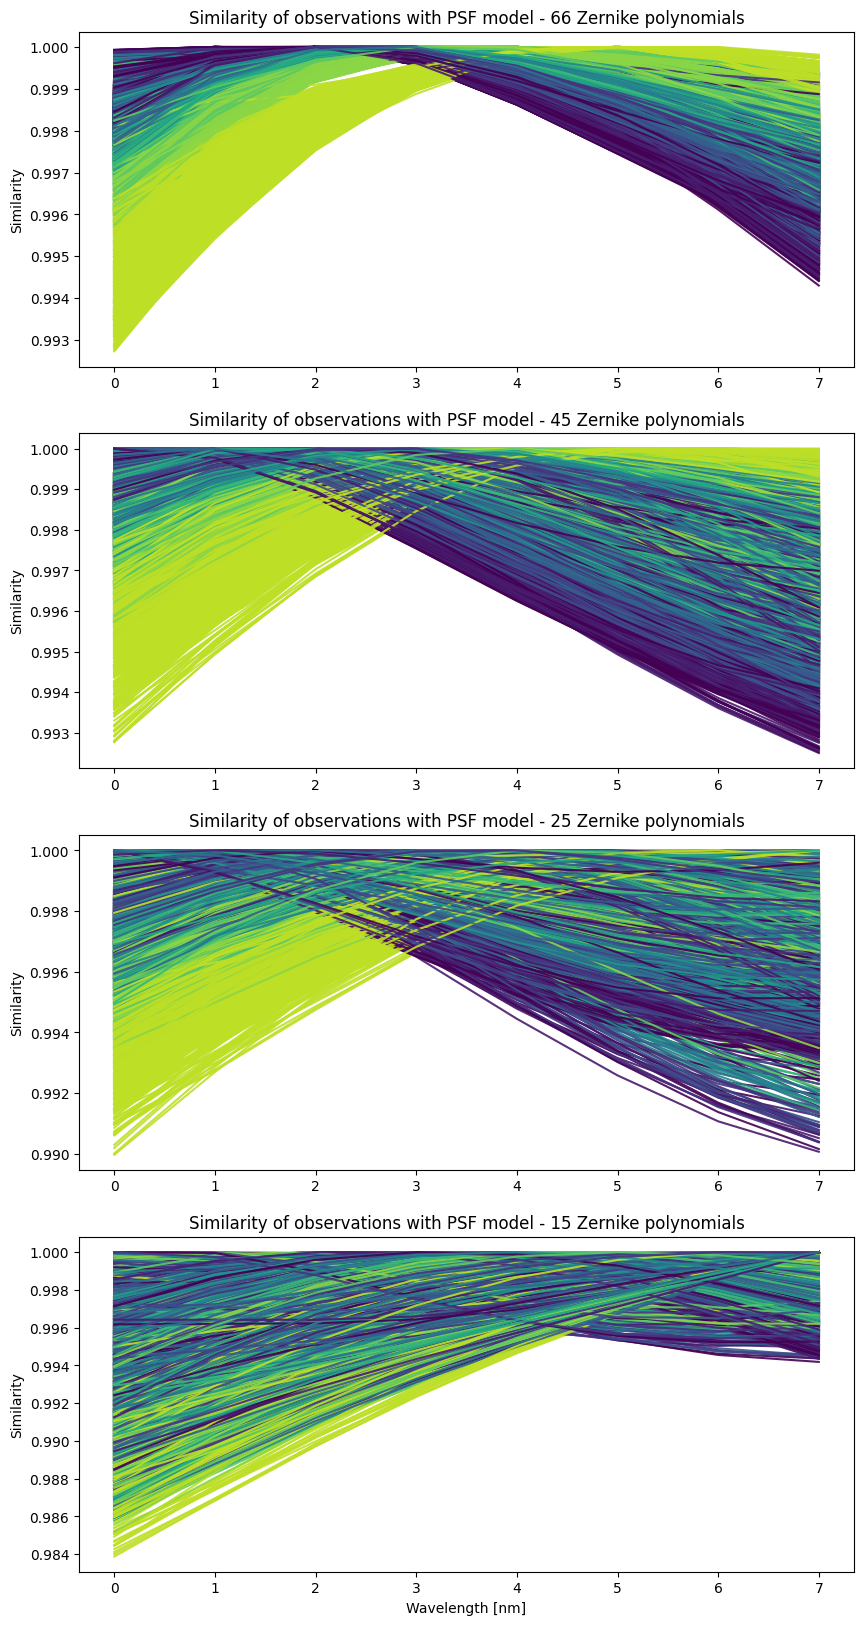

In [39]:
# Define 13 color palette
color_palette = plt.cm.viridis(np.linspace(0, 0.9, 13))

# Plot the difference with color code
fig, ax = plt.subplots(4,1,figsize=(10, 20))
for k, diff_train in enumerate(diff_train_list):
    for i, diff in enumerate(diff_train):
        ax[k].plot(diff, color=color_palette[dataset_gt_train['SED_ids'][i]], alpha=0.9)

    ax[k].set_title('Similarity of observations with PSF model - {} Zernike polynomials'.format(n_zks_list[k]))
    ax[k].set_ylabel('Similarity')
ax[k].set_xlabel('Wavelength [nm]')
plt.show()